In [51]:
# Loading pandas
import pandas as pd

# Loading date wrangling package
from datetime import datetime

# Reading the input data
d = pd.read_csv('C:/Users/AnalyticsMon/Summer/consumption_data.csv')
print(d.head)



<bound method NDFrame.head of            Date  consumption_day
0    10-01-2021          9971163
1    10-02-2021          8757426
2    10-03-2021          9152674
3    10-04-2021         11600000
4    10-05-2021         11500000
..          ...              ...
203   4/22/2022          9002116
204   4/23/2022          7795156
205   4/24/2022          7800370
206   4/25/2022         10200000
207   4/26/2022         10100000

[208 rows x 2 columns]>


In [52]:
import numpy as np

def create_X_Y(ts: list, lag: int) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y

In [53]:
# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [54]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [55]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'consumption_day',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [56]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 85348793188352.0000 - val_loss: 86214875021312.0000
Epoch 2/10
1/1 [==============================] - 0s 96ms/step - loss: 84113302224896.0000 - val_loss: 84765818486784.0000
Epoch 3/10
1/1 [==============================] - 0s 98ms/step - loss: 82745724239872.0000 - val_loss: 83437776011264.0000
Epoch 4/10
1/1 [==============================] - 0s 119ms/step - loss: 81421305643008.0000 - val_loss: 82077823270912.0000
Epoch 5/10
1/1 [==============================] - 0s 121ms/step - loss: 80060396601344.0000 - val_loss: 80703098191872.0000
Epoch 6/10
1/1 [==============================] - 0s 113ms/step - loss: 78715845345280.0000 - val_loss: 79327601360896.0000
Epoch 7/10
1/1 [==============================] - 0s 106ms/step - loss: 77450256056320.0000 - val_loss: 77946333167616.0000
Epoch 8/10
1/1 [==============================] - 0s 120ms/step - loss: 76205638287360.0000 - val_loss: 76590700560384.0000
Epoch 9/10
1/

In [61]:
deep_learner = DeepModelTS(
data = d,
Y_var = 'consumption_day',
lag = 48, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 312410921500672.0000 - val_loss: 263183717629952.0000
Epoch 2/10
1/1 [==============================] - 0s 214ms/step - loss: 254269345234944.0000 - val_loss: 190117666881536.0000
Epoch 3/10
1/1 [==============================] - 0s 226ms/step - loss: 199663584018432.0000 - val_loss: 230136343429120.0000
Epoch 4/10
1/1 [==============================] - 0s 231ms/step - loss: 143849074720768.0000 - val_loss: 214716605530112.0000
Epoch 5/10
1/1 [==============================] - 0s 220ms/step - loss: 130325246115840.0000 - val_loss: 254582257090560.0000
Epoch 6/10
1/1 [==============================] - 0s 224ms/step - loss: 178345178300416.0000 - val_loss: 112076123013120.0000
Epoch 7/10
1/1 [==============================] - 0s 221ms/step - loss: 542772633272320.0000 - val_loss: 120929862549504.0000
Epoch 8/10
1/1 [==============================] - 0s 233ms/step - loss: 583888590077952.0000 - val_loss: 1953117184720896

In [62]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = d['consumption_day'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 56ms/step


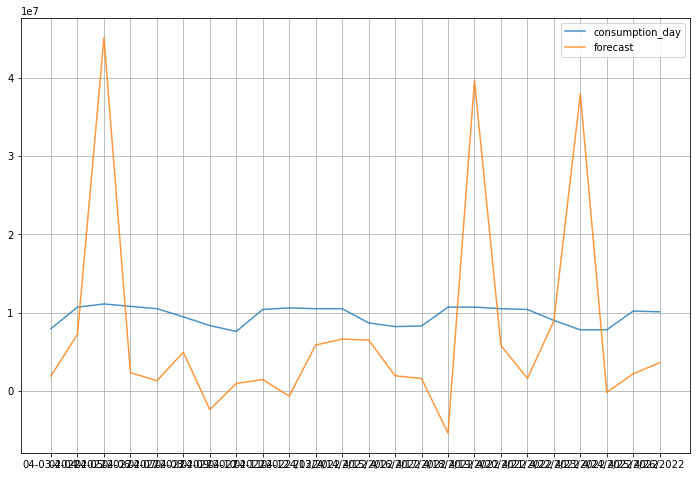

In [63]:
import matplotlib. pyplot as plt 
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['consumption_day', 'forecast']:
    plt.plot(
    'Date',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [66]:
# Creating the model using full data and forecasting n steps 
aheaddeep_learner = DeepModelTS(
data=d,
Y_var='consumption_day',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)
# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2558738846187520.0000 - val_loss: 1652680195833856.0000
Epoch 2/10
1/1 [==============================] - 0s 225ms/step - loss: 2074647310893056.0000 - val_loss: 1807149365723136.0000
Epoch 3/10
1/1 [==============================] - 0s 259ms/step - loss: 1696785886085120.0000 - val_loss: 1526530027028480.0000
Epoch 4/10
1/1 [==============================] - 0s 253ms/step - loss: 1635308663734272.0000 - val_loss: 1062223996780544.0000
Epoch 5/10
1/1 [==============================] - 0s 193ms/step - loss: 1338736742760448.0000 - val_loss: 797975194370048.0000
Epoch 6/10
1/1 [==============================] - 0s 247ms/step - loss: 1108556828901376.0000 - val_loss: 190125971603456.0000
Epoch 7/10
1/1 [==============================] - 0s 243ms/step - loss: 179326695768064.0000 - val_loss: 211662950891520.0000
Epoch 8/10
1/1 [==============================] - 0s 227ms/step - loss: 184967480999936.0000 - val_loss: 266267